<a href="https://colab.research.google.com/github/jmamath/Bottom-Sea-Detection/blob/master/VAE/sample_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the right libraries

In [0]:
!pip install --upgrade tensorflow
!pip install tensorflow_probability==0.8.0rc0 --user --upgrade

     |████████████████████████████████| 86.3MB 37kB/s 
     |████████████████████████████████| 450kB 29.5MB/s 
     |████████████████████████████████| 3.8MB 41.6MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled

     |████████████████████████████████| 2.5MB 4.9MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.8.0rc0 which is incompatible.
ERROR: gym 0.15.3 has requirement cloudpickle~=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
print(tf.__version__)
print(tfp.__version__)

2.0.0
0.8.0-rc0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU, Dense, Input, Bidirectional, Lambda, Masking, Concatenate, RNN
from generateDataset import DataGenerator
from tensorflow.keras.models import  Model, load_model
import tensorflow.keras.backend as K
import time

print("TensorFlow executing eagerly: {}".format(tf.executing_eagerly()))

TensorFlow executing eagerly: True


# Classes 

In [0]:
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.layers import GRUCell, Layer, Concatenate, Lambda, InputSpec, StackedRNNCells
import tensorflow as tf
import tensorflow.keras.backend as K

import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.python.keras.utils.generic_utils import has_arg


class GMM(Layer):    
    """
    Gaussian Mixture Model: 
    
    # Arguments
        k_mixture: Positive integer, number of mixture component.
        output_dim: Positive integer, dimensionality of generated output in our case it's equal to 3
        (x,y,eos) 2 dimensions for the position of a point, and the last dimension is for the end of stroke probability
        kernel_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
    
    """
    def __init__(self, 
                 k_mixture,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 debugging=False,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(GMM, self).__init__(**kwargs)
        self.output_dim = 3
        self.debugging=debugging
        self.supports_masking = True  
        self.k_mixture = k_mixture
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer=initializers.get(bias_initializer)
        self.input_spec = [InputSpec(min_ndim=self.output_dim),InputSpec(min_ndim=self.output_dim)]      

    def build(self, input_shape):
        input_dim = int(input_shape[0][-1])
    
        # Alpha
        self.alpha_kernel = self.add_weight(shape=[input_dim,self.k_mixture],
                                       initializer=self.kernel_initializer,
                                       name='alpha_kernel')
        self.alpha_bias = self.add_weight(shape=(1,self.k_mixture),
                                     initializer=self.bias_initializer,
                                     name='alpha_bias')
        # Sigma
        self.sigma_kernel = self.add_weight(shape=(input_dim,2*self.k_mixture),
                                       initializer=self.kernel_initializer,
                                       name='sigma_kernel')
        self.sigma_bias = self.add_weight(shape=(1,2*self.k_mixture),
                                     initializer=self.bias_initializer,
                                     name='sigma_bias')
        # Mu
        self.mu_kernel = self.add_weight(shape=(input_dim,2*self.k_mixture),
                                       initializer=self.kernel_initializer,
                                       name='mu_kernel')
        self.mu_bias = self.add_weight(shape=(1,2*self.k_mixture),
                                     initializer=self.bias_initializer,
                                     name='mu_bias') 

        # End of stroke probability eos = (p1,p2,p3)
        self.eos_kernel = self.add_weight(shape=(input_dim,3),
                                       initializer=self.kernel_initializer,
                                       name='end_of_stroke_kernel')
        self.eos_bias = self.add_weight(shape=(1,3),
                                     initializer=self.bias_initializer,
                                     name='end_of_stroke_bias') 
        
#        self.input_spec = [InputSpec(min_ndim=3, axes={-1: self.output_dim}),InputSpec(min_ndim=3, axes={-1: self.output_dim})]                                    
        super(GMM, self).build(input_shape)  # Be sure to call this at the end    

    def call(self, inputs, mask=None):
        hidden_layer, y = inputs
        # Get the mask to help us when computing probability density function and losses
        mask = hidden_layer._keras_mask
        mask = K.cast(mask, tf.float32)
        size_seq = K.sum(mask, axis=-1)
        y_pos = y[:,:,:2]
        y_eos = y[:,:,2:]
        if self.debugging:
            print("                     ------------------                     ")
            print_tensor(mask, "mask")
            print_tensor(y_pos, "y_pos")
            print_tensor(y_eos, "y_eos") 
            print_tensor(size_seq, "size_seq") 
        batch_size = (K.shape(hidden_layer)[0],)
        timesteps =  K.int_shape(hidden_layer)[1]
        
        # Computing the weights of the GMM
        mu = K.dot(hidden_layer,self.mu_kernel)
        mu = mu + self.mu_bias      
        
        sigma = K.dot(hidden_layer,self.sigma_kernel)
        sigma = sigma + self.sigma_bias
        sigma = K.exp(sigma)
        
        alpha = K.dot(hidden_layer,self.alpha_kernel)
        alpha = alpha + self.alpha_bias
        alpha = K.softmax(alpha)      

        eos = K.dot(hidden_layer,self.eos_kernel)
        eos = eos + self.eos_bias
        eos = K.softmax(eos)  
        
        if self.debugging:
            print("                     ------------------                     ")
            print_tensor(mu, "mu")
            print_tensor(sigma, "sigma")       
            print_tensor(eos, "eos")   
            print("                     ------------------                     ")        
        
        # Reshaping mu, sigma and rho to fit the tfp primitives
        mu = K.reshape(mu, batch_size + tuple([timesteps, self.k_mixture,self.output_dim-1]))     
        sigma = K.reshape(sigma, batch_size + tuple([timesteps, self.k_mixture,self.output_dim-1]))     

        # Initializing the distributions
        gaussians = tfd.MultivariateNormalDiag(loc=mu,
                                                scale_diag=sigma)          

        alpha_prob = tfd.Categorical(probs = alpha)
    
        gm = tfd.MixtureSameFamily(
                    mixture_distribution=alpha_prob,
                            components_distribution=gaussians)  
        Squeeze = Lambda(lambda x: K.squeeze(x, axis = 0))
        
        loss = -K.mean(gm.log_prob(y_pos) * mask, axis=-1) + K.mean(K.categorical_crossentropy(y_eos,eos), axis=-1)        
        sample = gm.sample(1) # * K.expand_dims(mask)
        sample = Squeeze(sample)
        output = Concatenate()([sample,eos])    
        if self.debugging:
            # compare the dim of each component of the reconstruction loss#            
            print("                     ------------------                     ")
            print_tensor(loss, "log probability of y")
            print_tensor(sample,"sample")
            print_tensor(output, "output")
            print("                     ------------------                     ")
        return output, loss 

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        batch_size = input_shape[0]
        timesteps =  input_shape[1]
        return [(batch_size, timesteps, self.output_dim), batch_size]
            
    
    def get_config(self):
        config = {"name": self.__class__.__name__,
                  'k_mixture': self.k_mixture,
                  'kernel_initializer':initializers.serialize(self.kernel_initializer),
                  'bias_initializer':initializers.serialize(self.bias_initializer)}
        base_config = super(GMM, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))   
    
    
    
class FastGRUCell(Layer):
    """Cell class for the GRU layer.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: sigmoid (`sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        reset_after: GRU convention (whether to apply reset gate after or
            before matrix multiplication). False = "before" (default),
            True = "after" (CuDNN compatible).
    """

    def __init__(self, units,                 
                 input_dim,
                 latent_dim,
                 debugging=False,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 reset_after=False,
                 **kwargs):
        super(FastGRUCell, self).__init__(**kwargs)
        self.units = units        
        self.input_dim = input_dim    # Our parameter
        self.latent_dim = latent_dim   # Our parameter
        self.debugging = debugging    # Our parameter
        self.state_size = self.units + self.latent_dim + self.input_dim  # Ours
        self.output_size = self.units  # Ours
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.reset_after = reset_after                
        self._dropout_mask = None
        self._recurrent_dropout_mask = None        
              
        
    def build(self, input_shape):
        input_dim = input_shape[-1]

        if isinstance(self.recurrent_initializer, initializers.Identity):
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self.kernel = self.add_weight(shape=(input_dim, self.units * 3),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 3),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            if not self.reset_after:
                bias_shape = (3 * self.units,)
            else:
                # separate biases for input and recurrent kernels
                # Note: the shape is intentionally different from CuDNNGRU biases
                # `(2 * 3 * self.units,)`, so that we can distinguish the classes
                # when loading and converting saved weights.
                bias_shape = (2, 3 * self.units)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            if not self.reset_after:
                self.input_bias, self.recurrent_bias = self.bias, None
            else:
                # NOTE: need to flatten, since slicing in CNTK gives 2D array
                self.input_bias = K.flatten(self.bias[0])
                self.recurrent_bias = K.flatten(self.bias[1])
        else:
            self.bias = None

        # update gate
        self.kernel_z = self.kernel[:, :self.units]
        self.recurrent_kernel_z = self.recurrent_kernel[:, :self.units]
        # reset gate
        self.kernel_r = self.kernel[:, self.units: self.units * 2]
        self.recurrent_kernel_r = self.recurrent_kernel[:,
                                                        self.units:
                                                        self.units * 2]
        # new gate
        self.kernel_h = self.kernel[:, self.units * 2:]
        self.recurrent_kernel_h = self.recurrent_kernel[:, self.units * 2:]

        if self.use_bias:
            # bias for inputs
            self.input_bias_z = self.input_bias[:self.units]
            self.input_bias_r = self.input_bias[self.units: self.units * 2]
            self.input_bias_h = self.input_bias[self.units * 2:]
            # bias for hidden state - just for compatibility with CuDNN
            if self.reset_after:
                self.recurrent_bias_z = self.recurrent_bias[:self.units]
                self.recurrent_bias_r = (
                    self.recurrent_bias[self.units: self.units * 2])
                self.recurrent_bias_h = self.recurrent_bias[self.units * 2:]
        else:
            self.input_bias_z = None
            self.input_bias_r = None
            self.input_bias_h = None
            if self.reset_after:
                self.recurrent_bias_z = None
                self.recurrent_bias_r = None
                self.recurrent_bias_h = None
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory
        slice_state = Lambda(lambda x: x[:,:self.units])
        slice_input = Lambda(lambda x: x[:,-self.input_dim:])
        slice_latent = Lambda(lambda x: x[:,self.units:(self.units+self.latent_dim)])
                        
        dumb_state = slice_input(h_tm1)
        latent = slice_latent(h_tm1)
        h_tm1 = slice_state(h_tm1)

        if self.debugging:
          print_tensor(states[0],"original state")
          print_tensor(h_tm1,"h_tm1")
          print_tensor(dumb_state,"dumb_state")
          print("slice latent between {} : {}".format(self.units, self.units+self.latent_dim))
          print_tensor(latent,"latent")
          print_tensor(self.recurrent_kernel,"recurrent_kernel")
          print_tensor(self.kernel,"kernel")

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=3)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=3)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_z = inputs * dp_mask[0]
                inputs_r = inputs * dp_mask[1]
                inputs_h = inputs * dp_mask[2]
            else:
                inputs_z = inputs
                inputs_r = inputs
                inputs_h = inputs

            x_z = K.dot(inputs_z, self.kernel_z)
            x_r = K.dot(inputs_r, self.kernel_r)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_z = K.bias_add(x_z, self.input_bias_z)
                x_r = K.bias_add(x_r, self.input_bias_r)
                x_h = K.bias_add(x_h, self.input_bias_h)

            if 0. < self.recurrent_dropout < 1.:
                h_tm1_z = h_tm1 * rec_dp_mask[0]
                h_tm1_r = h_tm1 * rec_dp_mask[1]
                h_tm1_h = h_tm1 * rec_dp_mask[2]
            else:
                h_tm1_z = h_tm1
                h_tm1_r = h_tm1
                h_tm1_h = h_tm1

            recurrent_z = K.dot(h_tm1_z, self.recurrent_kernel_z)
            recurrent_r = K.dot(h_tm1_r, self.recurrent_kernel_r)
            if self.reset_after and self.use_bias:
                recurrent_z = K.bias_add(recurrent_z, self.recurrent_bias_z)
                recurrent_r = K.bias_add(recurrent_r, self.recurrent_bias_r)

            z = self.recurrent_activation(x_z + recurrent_z)
            r = self.recurrent_activation(x_r + recurrent_r)

            # reset gate applied after/before matrix multiplication
            if self.reset_after:
                recurrent_h = K.dot(h_tm1_h, self.recurrent_kernel_h)
                if self.use_bias:
                    recurrent_h = K.bias_add(recurrent_h, self.recurrent_bias_h)
                recurrent_h = r * recurrent_h
            else:
                recurrent_h = K.dot(r * h_tm1_h, self.recurrent_kernel_h)

            hh = self.activation(x_h + recurrent_h)
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_z = matrix_x[:, :self.units]
            x_r = matrix_x[:, self.units: 2 * self.units]
            x_h = matrix_x[:, 2 * self.units:]

            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            if self.reset_after:
                # hidden state projected by all gate matrices at once                
                matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
                if self.use_bias:
                    matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)
            else:
                # hidden state projected separately for update/reset and new
                matrix_inner = K.dot(h_tm1,
                                     self.recurrent_kernel[:, :2 * self.units])

            recurrent_z = matrix_inner[:, :self.units]
            recurrent_r = matrix_inner[:, self.units: 2 * self.units]

            z = self.recurrent_activation(x_z + recurrent_z)
            r = self.recurrent_activation(x_r + recurrent_r)

            if self.reset_after:
                recurrent_h = r * matrix_inner[:, 2 * self.units:]
            else:
                recurrent_h = K.dot(r * h_tm1,
                                    self.recurrent_kernel[:, 2 * self.units:])

            hh = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        h = z * h_tm1 + (1 - z) * hh

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True
        
        state_out = K.concatenate([h, latent, dumb_state], axis=-1)
        return h, [state_out]

    def get_config(self):
        config = {'units': self.units,                  
                  'input_dim': self.input_dim,
                  'latent_dim': self.latent_dim,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation,
                  'reset_after': self.reset_after}
        base_config = super(FastGRUCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))    
    

class GMMCell(Layer):    
    """
    Gaussian Mixture Model: 
    TODO: write a proper documentation, use your paper based description
    # Arguments
        k_mixture: Positive integer, number of mixture component.
        output_size: Positive integer, dimensionality of generated output
        kernel_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
    
    """
    def __init__(self, 
                 k_mixture,
                 batch_size,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 debugging=False,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(GMMCell, self).__init__(**kwargs)
        self.output_size = 3 # Specific to stroke-5 format
        self.k_mixture = k_mixture
        self.debugging = debugging
        self.batch_size = batch_size
        self.state_size = 5 # Specific to stroke-5 format
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer=initializers.get(bias_initializer)

    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        # BatchNorm Layer
        # We put it here to match the order of weights between the learning
        # and the autoencoder        
        # Alpha
        self.alpha_kernel = self.add_weight(shape=[input_dim,self.k_mixture],
                                       initializer=self.kernel_initializer,
                                       name='alpha_kernel',
                                       use_resource=True )
        self.alpha_bias = self.add_weight(shape=(1,self.k_mixture),
                                     initializer=self.bias_initializer,
                                     name='alpha_bias',
                                     use_resource=True )
#        # Sigma
        self.sigma_kernel = self.add_weight(shape=(input_dim,2*self.k_mixture),
                                       initializer=self.kernel_initializer,
                                       name='sigma_kernel',
                                       use_resource=True )
        self.sigma_bias = self.add_weight(shape=(1,2*self.k_mixture),
                                     initializer=self.bias_initializer,
                                     name='sigma_bias',
                                     use_resource=True )
        # Mu
        self.mu_kernel = self.add_weight(shape=(input_dim,2*self.k_mixture),
                                       initializer=self.kernel_initializer,
                                       name='mu_kernel',
                                       use_resource=True )
        self.mu_bias = self.add_weight(shape=(1,2*self.k_mixture),
                                     initializer=self.bias_initializer,
                                     name='mu_bias',
                                     use_resource=True ) 
        # EOS
        self.eos_kernel = self.add_weight(shape=(input_dim,3),
                                       initializer=self.kernel_initializer,
                                       name='end_of_stroke_kernel')
        self.eos_bias = self.add_weight(shape=(1,3),
                                     initializer=self.bias_initializer,
                                     name='end_of_stroke_bias')      
                                  
        super(GMMCell, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, states, training=False):
        # Note how we ignore the states, this is because, we do not use 
        # a the previous value to perform a sample, we only use information from 
        # the RNN i.e hidden layer           
        hidden_layer = inputs
        batch_size = self.batch_size           
        # Computing the weights of the GMM
        mu = K.dot(hidden_layer,self.mu_kernel)
        mu = mu + self.mu_bias      
        
        sigma = K.dot(hidden_layer,self.sigma_kernel)
        sigma = sigma + self.sigma_bias
        sigma = K.exp(sigma)
        
        alpha = K.dot(hidden_layer,self.alpha_kernel)
        alpha = alpha + self.alpha_bias
        alpha = K.softmax(alpha)     
        
        eos = K.dot(hidden_layer,self.eos_kernel)
        eos = eos + self.eos_bias
        eos = K.softmax(eos)  
        
        if self.debugging:
            print("                     ------------------                     ")
            print_tensor(mu, "mu")
            print_tensor(sigma, "sigma")      
            print_tensor(eos, "eos")   
            print_tensor(batch_size, "batch size")   
            print("                     ------------------                     ")          
            
        
        # Reshaping mu and sigma to fit the tfp primitives        
        mu = K.reshape(mu,(batch_size, self.k_mixture,self.output_size-1))
        sigma = K.reshape(sigma, (batch_size, self.k_mixture,self.output_size-1))

        if self.debugging:
            print("                     ------------------                     ")
            print_tensor(mu, "mu")
            print_tensor(sigma, "sigma")   
            print("                     ------------------                     ")    
            
        # Initializing the distributions
        gaussians = tfd.MultivariateNormalDiag(loc = mu, scale_diag = sigma)
        alpha_prob = tfd.Categorical(probs = alpha)
    
        gm = tfd.MixtureSameFamily(
                    mixture_distribution=alpha_prob,
                            components_distribution=gaussians)  
        Squeeze = Lambda(lambda x: K.squeeze(x, axis = 0))
        
        sample = gm.sample(1)
        sample = Squeeze(sample)
        output = K.concatenate([sample,eos], axis=-1)
        if self.debugging:        
            print("                     ------------------                     ")
            print_tensor(sample, "sample")
            print_tensor(eos, "eos")
            print_tensor(output, "output")
            print("                     ------------------                     ")            
        
        return output, [output]   

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  'k_mixture': self.k_mixture,
                  'batch_size':self.batch_size,
                  'kernel_initializer':initializers.serialize(self.kernel_initializer),
                  'bias_initializer':initializers.serialize(self.bias_initializer)}
        base_config = super(GMMCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))    
            
                    
class AutoRegressiveStackedRNNCells(StackedRNNCells):
    """Wrapper allowing a stack of RNN cells to behave as a single cell during inference.
    In particular this cell feed the input from the first state
    and after all the cells are executed feed the final output
    back to the first state.
    Used to implement efficient stacked RNNs for inference.
    # Arguments
        cells: List of RNN cell instances.
    # Examples
    ```python
        cells = [
            keras.layers.LSTMCell(output_dim),
            keras.layers.LSTMCell(output_dim),
            keras.layers.LSTMCell(output_dim),
        ]
        inputs = keras.Input((timesteps, input_dim))
        x = keras.layers.RNN(cells)(inputs)
    ```
    """

    def call(self, inputs, states, constants=None, **kwargs):
        # Recover per-cell states.
     
        nested_states = []
        for state in states:
            nested_states.append([states[0]])
            states = states[1:]

        # Call the cells in order and store the returned states.
        # Execute the first cell separately to treat the input as a state        
        new_nested_states = []
        cell1 = self.cells[0]
        input_dim = cell1.input_dim    
        latent_dim = cell1.latent_dim    
        state1 = nested_states.pop(0)[0]
        
        # Exchanging the position of the inputs which is dumb and the dumb state
        # So that the input goes through the state space for inference, to avoid
        # unnecessary loops
        input1 = state1[:,-(latent_dim+input_dim):]  # input_dim is for stroke-5 format
        latent_vector = state1[:,-(latent_dim+input_dim):-input_dim]
        state1 = [state1]

        if has_arg(cell1.call, 'constants'):
            inputs, states = cell1.call(input1,state1, 
                                       constants=constants,
                                       **kwargs)
        else:
            inputs, states = cell1.call(input1, state1, **kwargs)
        new_nested_states.append(states)
        
        # Go through the all the other states
        for cell, states in zip(self.cells[1:], nested_states):
            if has_arg(cell.call, 'constants'):
                inputs, states = cell.call(inputs, states,
                                           constants=constants,
                                           **kwargs)
            else:
                inputs, states = cell.call(inputs, states, **kwargs)
            new_nested_states.append(states)

        # Now we take the last output and we concatenate it with the 
        # first state, so that we can further use it as an input 
        new_states = []
        state1 = new_nested_states.pop(0)[0]
        state1_ = state1[:,:-(latent_dim+input_dim)]
        new_input = K.concatenate([latent_vector, inputs], axis=-1)  # concatenate z and new prediction 
        state1 = K.concatenate([state1_,new_input], axis=-1)    # Get the new state [h1, z, x'] to feed in the loop
        new_states += [state1]
 
        for cell_states in new_nested_states:
            new_states += cell_states
                     
        return inputs, new_states  

def print_tensor(tensor,name):
    print("{} :{}".format(name, tensor))

# Fast Decoder

In [0]:
data = np.load("a.npy")

# Select globals for testing
batch_size = data.shape[0] 
timesteps = data.shape[1]-1   # sequence of points (offsets)
input_dim = data.shape[-1]   

hidden_dim = 32 
k_mixt = 10     # nb of mixtures 

latent_dim = 32

data_generator = DataGenerator(data, batch_size)
for x, y in data_generator:
  global_input_output = x
  decoder_input = y

In [0]:
inference_net = load_model("new_inference_net.h5")
generative_net = load_model("new_generative_net.h5",custom_objects={"GMM":GMM})

In [0]:
var_en = inference_net.variables
var_de = generative_net.variables

# Print variable of a model
def print_variable(var, name):
  print("variables {}  - length {} ".format(name, len(var)))
  for i in range(len(var)):
    print("trained {} - {}".format(var[i].name, var[i].shape))

In [0]:
print_variable(var_en, "encoder")

variables encoder  - length 8 
trained bidirectional_1/forward_gru_2/kernel:0 - (5, 96)
trained bidirectional_1/forward_gru_2/recurrent_kernel:0 - (32, 96)
trained bidirectional_1/forward_gru_2/bias:0 - (2, 96)
trained bidirectional_1/backward_gru_2/kernel:0 - (5, 96)
trained bidirectional_1/backward_gru_2/recurrent_kernel:0 - (32, 96)
trained bidirectional_1/backward_gru_2/bias:0 - (2, 96)
trained dense_2/kernel:0 - (64, 64)
trained dense_2/bias:0 - (64,)


In [0]:
print_variable(var_de, "decoder")

variables decoder  - length 13 
trained dense_3/kernel:0 - (32, 32)
trained dense_3/bias:0 - (32,)
trained gru_3/kernel:0 - (37, 96)
trained gru_3/recurrent_kernel:0 - (32, 96)
trained gru_3/bias:0 - (2, 96)
trained GMM/alpha_kernel:0 - (32, 20)
trained GMM/alpha_bias:0 - (1, 20)
trained GMM/sigma_kernel:0 - (32, 40)
trained GMM/sigma_bias:0 - (1, 40)
trained GMM/mu_kernel:0 - (32, 40)
trained GMM/mu_bias:0 - (1, 40)
trained GMM/end_of_stroke_kernel:0 - (32, 3)
trained GMM/end_of_stroke_bias:0 - (1, 3)


In [0]:
####### DECODER NETWORK ####### 
def fast_decoder_net(batch_size, hidden_dim, timesteps, input_dim, latent_dim):
  # The decoder takes the input sequence and the initial state passed by the encoder
  # to compute the prediction. Note that we use a dumb state, that is required to have our
  # GMMCell to fit in the RNN framework, even if it won't be used.

  # Here the input is just dumb. We only need it to indicate the size of the output sequence to RNN.
  dumb_input = Input(shape=(timesteps,input_dim+latent_dim), batch_size=batch_size, name="Input_Sequence") 
  
  # the real input is the latent vector (i.e z), and S0 which is the standard (0,0,1,0,0)
  # We are also going to give S0 to GMM as input state.
  latent_vector = Input(shape=(latent_dim,), batch_size=batch_size)  
  S0 = Input(shape=(input_dim,), batch_size=batch_size)  
  
  # Get h0
  h0 = Dense(hidden_dim, activation="tanh")(latent_vector)

  # Get the state of FastGRUCell
  gru_state = Concatenate()([h0, latent_vector, S0])

  gru = FastGRUCell(hidden_dim, input_dim, latent_dim=latent_dim, debugging=False, reset_after=True)
  gmm = GMMCell(k_mixture=20, batch_size=batch_size)

  cells = [gru, gmm]

  stacked = AutoRegressiveStackedRNNCells(cells)

  sample = RNN(stacked, input_shape=(timesteps, input_dim), return_sequences=True)(dumb_input, initial_state=[gru_state, S0])             
  model = Model([dumb_input,latent_vector, S0], sample, name="fast_decoder_net")  
  return model 


In [0]:
fast_decoder = fast_decoder_net(batch_size, hidden_dim, timesteps, input_dim, latent_dim)

In [0]:
# Print variable of the decoder
def compare_variables(var1, var2, name1, name2):
  print("variables length. Model {} = {}.  Model {} = {}".format(name1, len(var1), name2, len(var2)))
  assert len(var1) == len(var2)
  for i in range(len(var1)):
    print("trained {} - {}       |       inference {} - {}".format(var1[i].name, var1[i].shape, var2[i].name, var2[i].shape))
    
var_fast = fast_decoder.variables
compare_variables(var_de, var_fast, "real decoder", "fast decoder")

variables length. Model real decoder = 13.  Model fast decoder = 13
trained dense_3/kernel:0 - (32, 32)       |       inference dense/kernel:0 - (32, 32)
trained dense_3/bias:0 - (32,)       |       inference dense/bias:0 - (32,)
trained gru_3/kernel:0 - (37, 96)       |       inference rnn/kernel:0 - (37, 96)
trained gru_3/recurrent_kernel:0 - (32, 96)       |       inference rnn/recurrent_kernel:0 - (32, 96)
trained gru_3/bias:0 - (2, 96)       |       inference rnn/bias:0 - (2, 96)
trained GMM/alpha_kernel:0 - (32, 20)       |       inference rnn/alpha_kernel:0 - (32, 20)
trained GMM/alpha_bias:0 - (1, 20)       |       inference rnn/alpha_bias:0 - (1, 20)
trained GMM/sigma_kernel:0 - (32, 40)       |       inference rnn/sigma_kernel:0 - (32, 40)
trained GMM/sigma_bias:0 - (1, 40)       |       inference rnn/sigma_bias:0 - (1, 40)
trained GMM/mu_kernel:0 - (32, 40)       |       inference rnn/mu_kernel:0 - (32, 40)
trained GMM/mu_bias:0 - (1, 40)       |       inference rnn/mu_bias:

## Test Fast Decoder

In [0]:
def testFastDecoder(batch_size, hidden_dim, timesteps, input_dim):
    print("Checking compilation...")
    print("---------------------")
    fast_decoder = fast_decoder_net(batch_size, hidden_dim, timesteps, input_dim, latent_dim)
    print("Compilation is working")
    print("Checking forward propagation...")
    print("---------------------")        
    decoder_input = np.random.random((batch_size, timesteps ,input_dim + latent_dim))
    h1 = np.random.random((batch_size, latent_dim))
    S0 = np.random.random((batch_size, input_dim))
    fast_decoder.predict([decoder_input, h1,S0])
    print("Forward propagation is working")
    print("---------------------")
    # We don't need to enable backpropagation 
    # because this network is used exclusively for inference 
    fast_decoder.save("fast_decoder.h5")
    print("Fast Decoder saved \n")
    print("---------------------")    
    loaded = load_model("fast_decoder.h5",custom_objects={'AutoRegressiveStackedRNNCells':AutoRegressiveStackedRNNCells,
                                                     'FastGRUCell':FastGRUCell ,
                                                     'GMMCell':GMMCell},compile=False)
    print("Fast Decoder loaded is ready for inference \n")
    print("---------------------")  
    ## Investigate the configuration, both models don't share the same number of weights
    loaded.predict([decoder_input, h1,S0])
    print("Fast Decoder is fully operational ! Great job")



In [0]:
testFastDecoder(batch_size, hidden_dim, timesteps, input_dim)

Checking compilation...
---------------------
Compilation is working
Checking forward propagation...
---------------------
Forward propagation is working
---------------------
Fast Decoder saved 

---------------------
Fast Decoder loaded is ready for inference 

---------------------
Fast Decoder is fully operational ! Great job


# Fast Encoder Decoder
Sample a reconstruction

In [0]:
def sample_inference_net(inference_net, encoder_input):
    latent_space = inference_net(encoder_input)
    mean, log_var = tf.split(latent_space, 2, axis=-1)
    var = K.exp(log_var)
    batch_size = K.int_shape(mean)[0]    
    hidden_dim = K.int_shape(mean)[-1]
    eps = K.random_normal(shape=(batch_size,hidden_dim))
    z = mean + eps*var    
    return z


In [0]:
def fast_encoder_decoder(batch_size, hidden_dim, timesteps, input_dim, latent_dim, inference_net, weights_decoder):
    # input to reconstruct
    input_ = Input(batch_shape=(batch_size, timesteps,input_dim),name='Sequence_Input')        
    # dumb_input is a variable to inform RNN about the dimension of the output
    dumb_input = Input(batch_shape=(batch_size, timesteps,input_dim + latent_dim),name='Dumb_Input')
    # S0 is the input to the decoder, we pass it as a state
    S0 = Input(batch_shape=(batch_size,input_dim),name='S0')
    
    fast_decoder = fast_decoder_net(batch_size, hidden_dim, timesteps, input_dim, latent_dim)
    fast_decoder.set_weights(weights_decoder)
      
    latent_vector = sample_inference_net(inference_net, input_)      

    sample = fast_decoder([dumb_input, latent_vector, S0])        
    model = Model([input_, dumb_input, S0], sample)
    return model


In [0]:
weights_decoder = generative_net.get_weights()
fast_auto_encoder = fast_encoder_decoder(batch_size, hidden_dim, timesteps, input_dim, latent_dim, inference_net, weights_decoder)
fast_auto_encoder.save("fast_autoencoder.h5")

In [0]:
# fast_auto_encoder.save("fast_encoder_decoder.h5")
fast = load_model("fast_autoencoder.h5",custom_objects={'AutoRegressiveStackedRNNCells':AutoRegressiveStackedRNNCells,
                                                     'FastGRUCell':FastGRUCell ,
                                                     'GMMCell':GMMCell},compile=False)


In [0]:
fast_auto_encoder.input

[<tf.Tensor 'Sequence_Input_8:0' shape=(120, 221, 5) dtype=float32>,
 <tf.Tensor 'Dumb_Input_8:0' shape=(120, 221, 37) dtype=float32>,
 <tf.Tensor 'S0_8:0' shape=(120, 5) dtype=float32>]

In [0]:
dumb_input = np.random.normal(size=(batch_size, timesteps, latent_dim + input_dim))
S0 = decoder_input[:,0]

In [0]:
%%time
sample = fast.predict([global_input_output, dumb_input, S0])

CPU times: user 1.13 s, sys: 23.1 ms, total: 1.15 s
Wall time: 955 ms


In [0]:
def visualize_reconstruction(coordinates, coordinates_reconstructed, i=None, save=None):
    """ 
    Visualizes stroke3 coordinates
    Args:
        coordinate: list or numpy object of all the sequence of stroke
        characters: list or numpy object  of all characters represented
        i: Int. Index of the character to represent with the sequence of strokes
    """
    fig, ax = plt.subplots(1,2, figsize=(8, 4))
    if i is not None:
        coords_ = coordinates[i]
        coords_pred = coordinates_reconstructed[i]
    else:
        coords_ = coordinates
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()    
    stroke = []
    for x, y, eos in coords_:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax[0].plot(coords[0], coords[1], 'k')
            ax[0].set_title("original")                                    
            stroke = []
    for x, y, eos in coords_pred:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax[1].plot(coords[0], coords[1], 'k')
            ax[1].set_title("reconstruction")                                    
            stroke = []
    if save is not None:
        fig.savefig("comparison_{}.png".format(i))
        
def offsets_to_coordinates(offsets):
    """
    convert from offsets to coordinates and transform to dtype float if not.
    """
    len_offsets = len(offsets)
    coordinates_list = []
    for i in range(len_offsets):
        coordinates = np.concatenate([np.cumsum(offsets[i][:,:2], axis=0), offsets[i][:,-1:]], axis=1).astype(np.float32)
        coordinates_list.append(coordinates)
    return np.array(coordinates_list)

def toStroke3(arr):
    """ 
    Transform a stroke 5 array to a stroke 3 array. 
    We need to start from the end of the array because of the 
    last condition p3 that encodes when to stop.
    """  
    array = np.copy(arr)
    len_list = len(array)
    for i in range(len_list):
        len_stroke = len(array[i])
        for j in range(len_stroke-1,-1,-1):                                                     
            if (array[i,j,4] == 1. and array[i,j-1,2] == 1.):
                array[i,j,2] = 1.   
            elif array[i,j,4] == 1.:
                array[i,j,2] = 0. 
            elif array[i,j,3] == 1.:
                array[i,j,2] = 1.                   
            else:
                array[i,j,2] = 0.                 
    return array[:,:,:3]  
        
def get_one_hot(tensor):
  new_tensor = np.copy(tensor)
  n_sample = len(tensor)
  for i in range(n_sample):    
    correct_class = np.argmax(new_tensor[i,:,2:], axis=1)
    eos = np.eye(3)[correct_class]
    new_tensor[i,:,2:] = eos
  return new_tensor    


In [0]:
def visualize_prediction(coordinates, coordinates_predicted, i=None, save=None):
    """ 
    Visualizes stroke3 coordinates
    Args:
        coordinate: list or numpy object of all the sequence of stroke
        characters: list or numpy object  of all characters represented
        i: Int. Index of the character to represent with the sequence of strokes
    """
    fig, ax = plt.subplots(1, figsize=(8, 4))
    if i is not None:
        coords_ = coordinates[i]
        coords_pred = coordinates_predicted[i]
    else:
        coords_ = coordinates
    ax.invert_yaxis()       
    stroke = []
    for x, y, eos in coords_:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k', )                                               
            stroke = []
    for x, y, eos in coords_pred:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'g')          
            stroke = []
    ax.set_title("Black: input data. Green: reconstruction")
    if save is not None:
        fig.savefig("comparison_{}.png".format(i))




In [0]:
strokes = toStroke3(global_input_output)
coords = offsets_to_coordinates(strokes)

new_pred = get_one_hot(sample)
strokes_pred = toStroke3(new_pred)
coords_pred = offsets_to_coordinates(strokes_pred)

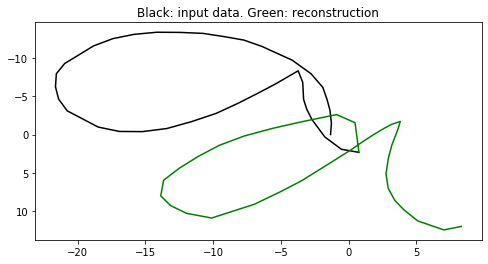

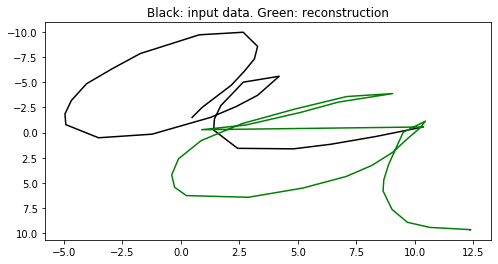

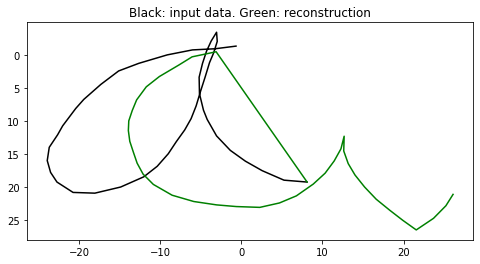

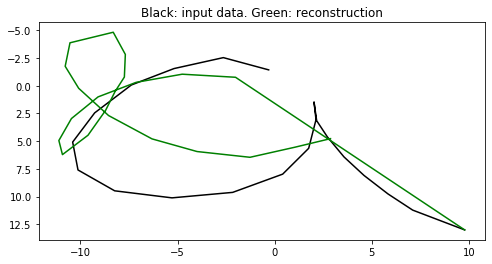

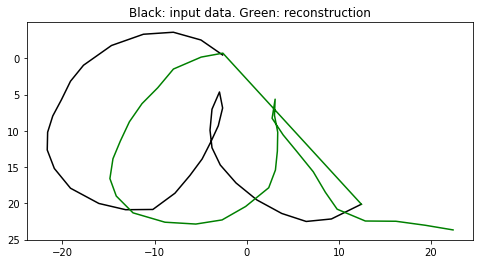

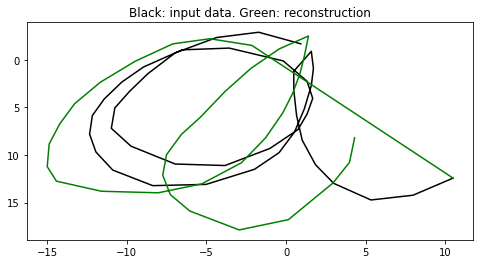

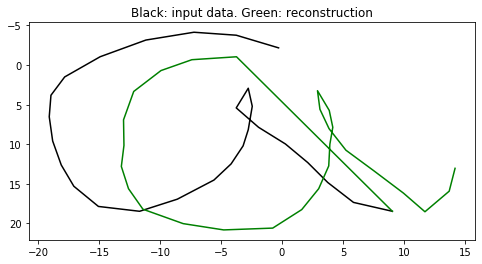

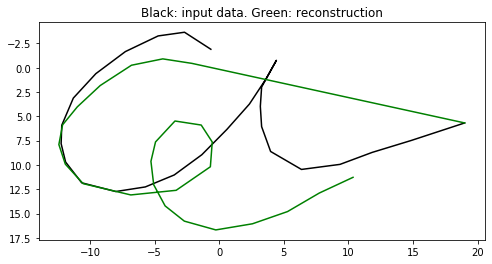

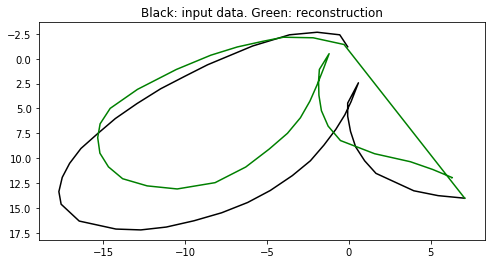

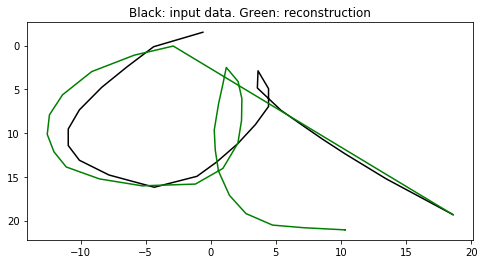

In [0]:
selected_coords = np.random.uniform(0,120,10).astype(np.int16)

for i in selected_coords:
  visualize_prediction(coords, coords_pred, i)

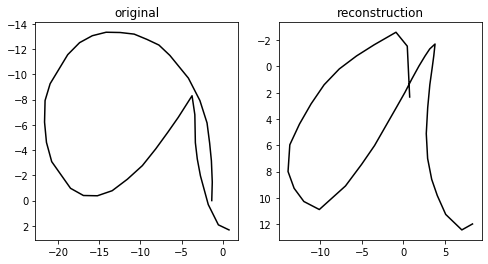

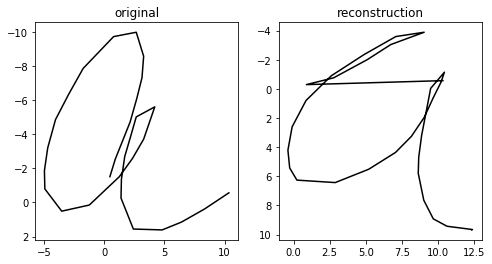

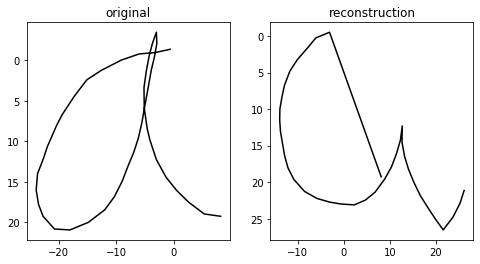

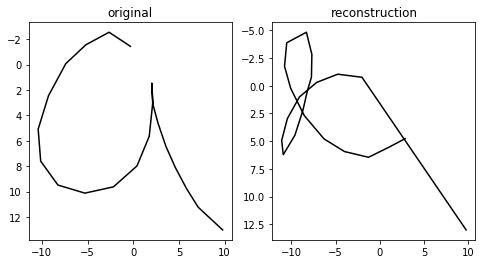

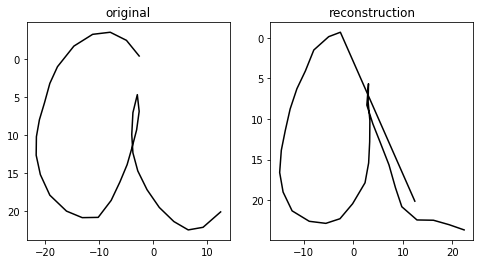

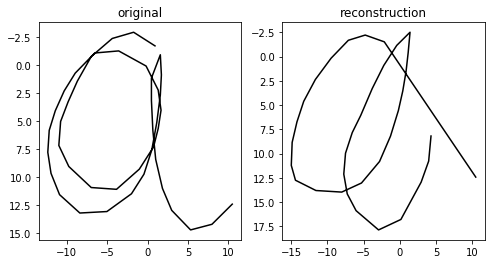

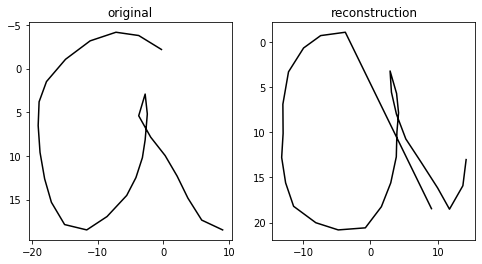

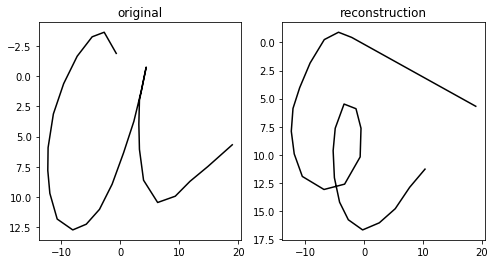

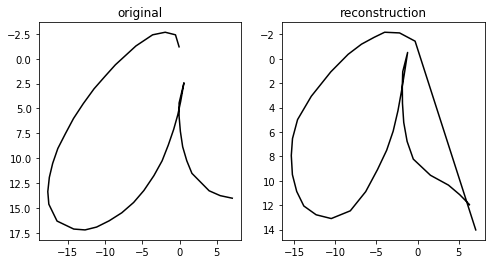

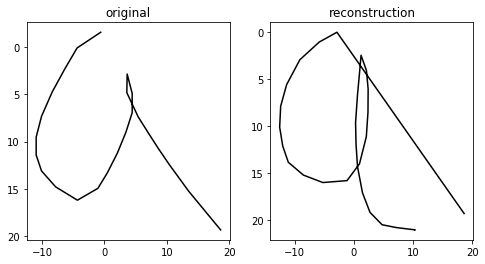

In [0]:
for i in selected_coords:
  visualize_reconstruction(coords, coords_pred, i)

# Sample from z ~ N(0,I)

In [0]:
def sample_random_normal(batch_size, hidden_dim, ones):    
    eps = tf.random.normal(shape=(batch_size, hidden_dim)) 
    z = ones * eps           
    return z

def decode_normal(batch_size, hidden_dim, timesteps, input_dim, latent_dim, weights_decoder):          
    # dumb_input is a variable to inform RNN about the dimension of the output
    dumb_input = Input(batch_shape=(batch_size, timesteps,input_dim + latent_dim),name='Dumb_Input')
    # S0 is the input to the decoder, we pass it as a state
    S0 = Input(batch_shape=(batch_size,input_dim),name='S0')
    # ones is meant to be use to generate z~N(0,I)
    ones = Input(batch_shape=(batch_size,hidden_dim),name='ones')
        
    fast_decoder = fast_decoder_net(batch_size, hidden_dim, timesteps, input_dim, latent_dim)
    fast_decoder.set_weights(weights_decoder)
      
    latent_vector = sample_random_normal(batch_size, hidden_dim, ones)     

    sample = fast_decoder([dumb_input, latent_vector, S0])        
    model = Model([dumb_input, S0, ones], sample)
    return model    

In [0]:
sample_normal = decode_normal(batch_size, hidden_dim, timesteps, input_dim, latent_dim, weights_decoder)
sample_normal.input 

In [0]:
ones = tf.ones(shape=(batch_size,hidden_dim))
dumb_input = np.random.normal(size=(batch_size, timesteps, latent_dim + input_dim))
S0 = decoder_input[:,0]

sample = sample_normal.predict([dumb_input, S0, ones])

In [0]:
def visualize_sample(coordinates, i=None, save=None):
    """ 
    Visualizes stroke3 coordinates
    Args:
        coordinate: list or numpy object of all the sequence of stroke
        characters: list or numpy object  of all characters represented
        i: Int. Index of the character to represent with the sequence of strokes
    """
    fig, ax = plt.subplots(1, figsize=(8, 4))
    if i is not None:
        coords_ = coordinates[i]        
    else:
        coords_ = coordinates
    ax.invert_yaxis()       
    stroke = []
    for x, y, eos in coords_:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k', )                                               
            stroke = []    
    ax.set_title("Sample from z ~ N(0,I). ")
    if save is not None:
        fig.savefig("comparison_{}.png".format(i))        


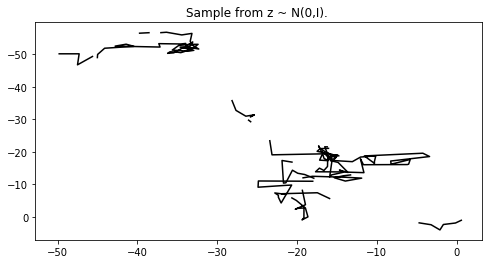

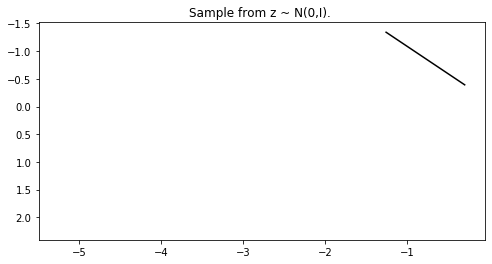

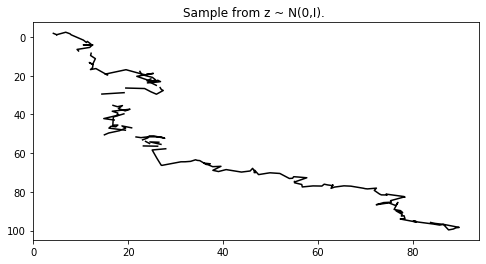

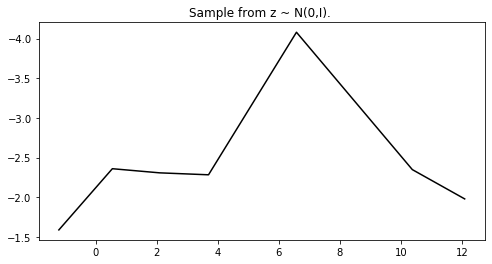

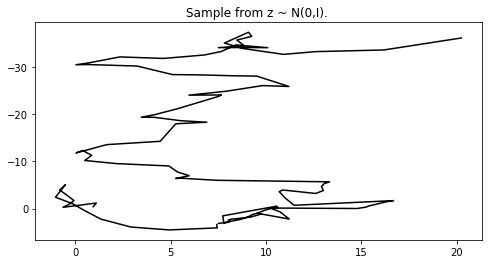

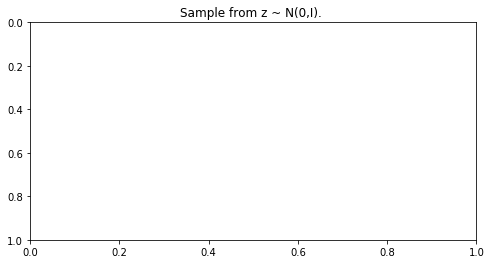

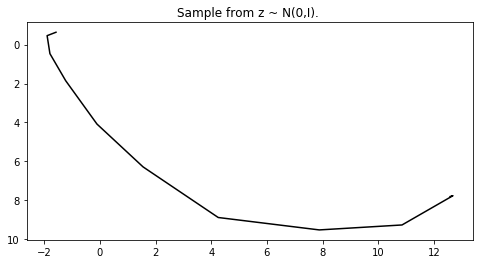

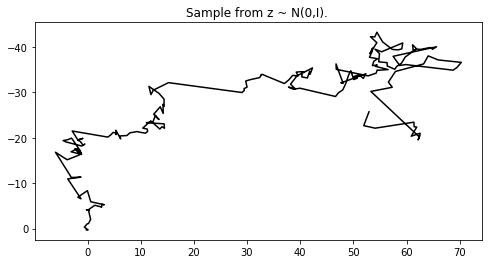

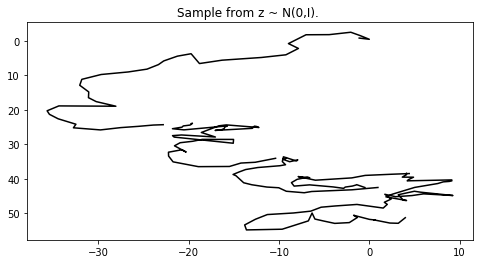

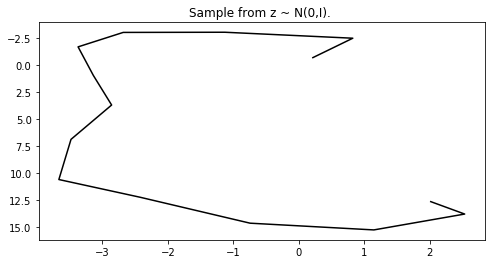

In [0]:
new_pred = get_one_hot(sample)
strokes_pred = toStroke3(new_pred)
coords_pred = offsets_to_coordinates(strokes_pred)

selected_coords = np.random.uniform(0,120,10).astype(np.int16)

for i in selected_coords:
  visualize_sample(coords_pred, i)

# Interpoling between two elements

We are going to use the Spherical Linear Interpolation slerp.

$$
slerp(p,q,t) = p \frac{\sin(1-t) \theta}{sin(\theta)} + 
q \frac{\sin(t \theta)}{sin(\theta)} 
$$
with
$$\theta = arcos(\frac{<p,q>}{||p|| ||q||} )$$

In [0]:
def slerp_np(p,q,scale):
  """ Spherically interpolate between p and q.
  Args:
    p: np array of shape hidden_dim
    q: np array of shape hidden_dim
    scale: set of points in [0,1], usually taken up with np linspace
  Returns:
    interpolations: np array of size (len_scale, hidden_dim)"""
  interpolations = []
  theta = np.arccos(np.dot(p,q)/ (np.linalg.norm(p) * np.linalg.norm(q)))
  sin_theta = np.sin(theta)
  if sin_theta == 0:
    return p * (1-t) + t * q
  for t in scale:
    interpolations.append(p * np.sin((1-t) * theta) / sin_theta + q * np.sin(t*theta) / sin_theta)
  return np.array(interpolations)

In [0]:
def test_slerp(hidden_dim):
  a = np.random.standard_normal(size=(hidden_dim))
  b = np.random.standard_normal(size=(hidden_dim))
  t = np.linspace(0,1,10)
  return slerp(a,b,t)

r = test_slerp(hidden_dim)
r.shape

(10, 32)

In [0]:
@tf.function
def slerp_tf(p,q,t):
  """ Spherically interpolate between p and q.
  Args:
    p: tf tensor of shape hidden_dim
    q: tf tensor of shape hidden_dim
    scale: set of points in [0,1], usually taken up with tf linspace
  Returns:
    interpolations: tf tensor of size (len_scale, hidden_dim)"""
  interpolations = p   
  theta = tf.acos(K.batch_dot(p,q)/ (tf.norm(p) * tf.norm(q)))
  sin_theta = tf.sin(theta) 
  print(sin_theta) 
  for i in range(1, t.shape[0]-1, 1):
    if sin_theta == 0:
      slerp_i = p * (1-t[i]) + q * t[i]      
      print("1rst case {}".format(slerp_i))
      # import pdb; pdb.set_trace()
      interpolations = tf.concat([interpolations, slerp_i], axis=0)
    else:
      slerp_i = p * tf.sin((1-t[i]) * theta) / sin_theta + q * tf.sin(t[i]*theta) / sin_theta
      # print("2nd case {}".format(slerp_i))
      interpolations = tf.concat([interpolations, slerp_i], axis=0)
    # print("interpolation length : {}".format(len(interpolations)))
  interpolations = tf.concat([interpolations, q], axis=0)
  return interpolations 

In [0]:
def test_slerp_tf(hidden_dim, size_scale):
  a = tf.random.normal(shape=np.array([1, hidden_dim]))
  b = tf.random.normal(shape=np.array([1, hidden_dim]))
  t = np.linspace(0.,1.,size_scale, dtype=np.float32)
  return slerp_tf(a,b,t)

r = test_slerp_tf(hidden_dim, 10)
print("interpolations shape : {}".format(r.shape))
print("interpolation type: {}".format(type(r)))


Tensor("Sin:0", shape=(1, 1), dtype=float32)
1rst case Tensor("add:0", shape=(1, 32), dtype=float32)
1rst case Tensor("add:0", shape=(1, 32), dtype=float32)
1rst case Tensor("add:0", shape=(1, 32), dtype=float32)
1rst case Tensor("add:0", shape=(1, 32), dtype=float32)
1rst case Tensor("add:0", shape=(1, 32), dtype=float32)
1rst case Tensor("add:0", shape=(1, 32), dtype=float32)
1rst case Tensor("add:0", shape=(1, 32), dtype=float32)
1rst case Tensor("add:0", shape=(1, 32), dtype=float32)
interpolations shape : (10, 32)
interpolation type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [0]:
def encode_interpolation(timesteps, input_dim, inference_net):
    # inputs to interpolate between
    input1 = Input(batch_shape=(1, timesteps,input_dim),name='Sequence_1')        
    input2 = Input(batch_shape=(1, timesteps,input_dim),name='Sequence_2')            
      
    # Get the latent vector of each input
    latent1 = sample_inference_net(inference_net, input1)  
    latent2 = sample_inference_net(inference_net, input2)

    model = Model([input1, input2], [latent1, latent2])
    return model
    
def decode_interpolation(nb_interpolation, latent_dim, weights_decoder):
    # dumb_input is a variable to inform RNN about the dimension of the output
    dumb_input = Input(batch_shape=(nb_interpolation, timesteps,input_dim + latent_dim),name='Dumb_Input')
    latent_interpolation = Input(batch_shape=(nb_interpolation, latent_dim))
    # S0 is the input to the decoder, we pass it as a state
    S0 = Input(batch_shape=(nb_interpolation, input_dim),name='S0')
                

    fast_decoder = fast_decoder_net(nb_interpolation, hidden_dim, timesteps, input_dim, latent_dim)
    fast_decoder.set_weights(weights_decoder)

    sample = fast_decoder([dumb_input, latent_interpolation, S0])        
    model = Model([dumb_input, latent_interpolation, S0], sample)
    return model

def compute_interpolation(encode_interpolation, decode_interpolation, input1, input2, scale, dumb_input, S0):
    latent1, latent2 = encode_interpolation([input1, input2])
    latent_interpolation = slerp_tf(latent1, latent2, scale)
    sample = decode_interpolation([dumb_input, latent_interpolation, S0])
    return sample


In [0]:
input1 = global_input_output[0:1]
input2 = global_input_output[10:11]

nb_interpolation=10
scale = np.linspace(0.,1.,nb_interpolation, dtype=np.float32)
dumb_input = np.random.normal(size=(nb_interpolation, timesteps, latent_dim + input_dim))
S0 = decoder_input[:nb_interpolation,0]

encode_interp = encode_interpolation(timesteps, input_dim, inference_net)
decode_interp = decode_interpolation(nb_interpolation, latent_dim, weights_decoder)

In [0]:
sample = compute_interpolation(encode_interp, decode_interp, input1, input2, scale, dumb_input, S0)

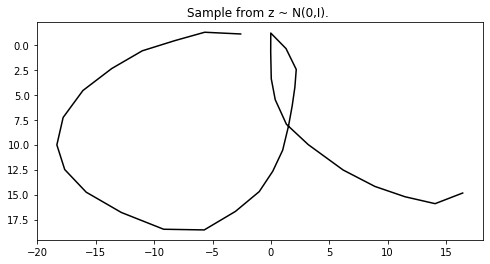

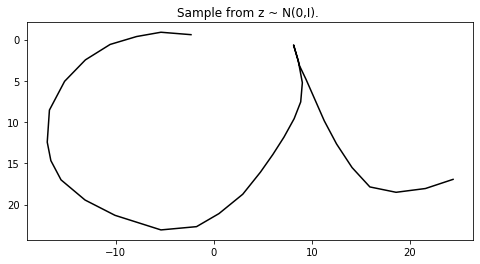

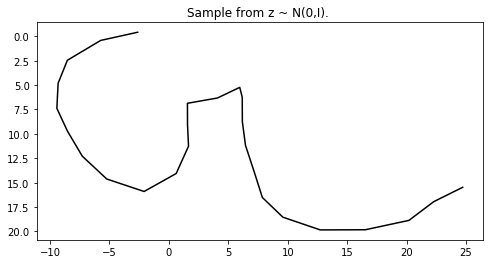

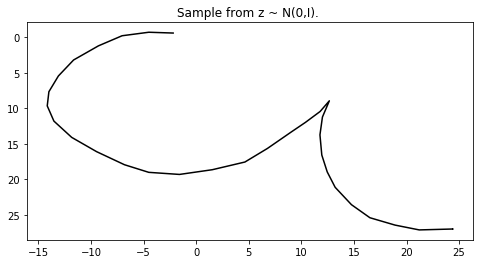

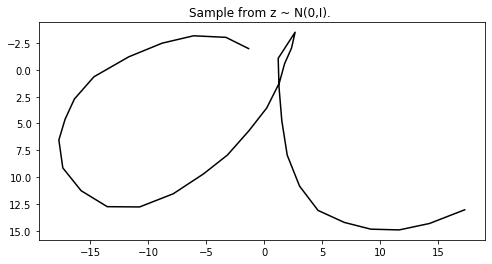

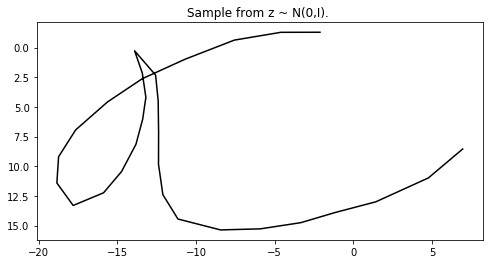

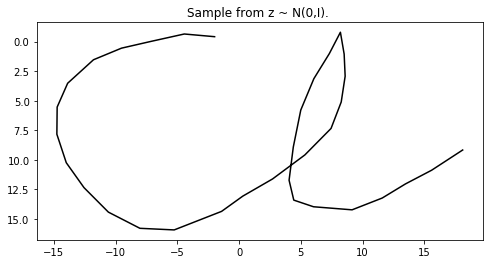

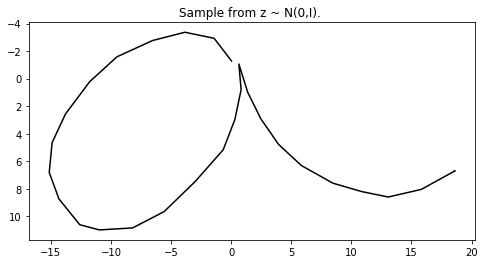

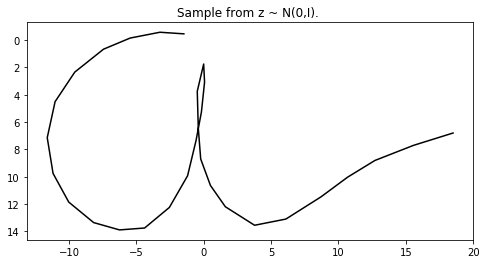

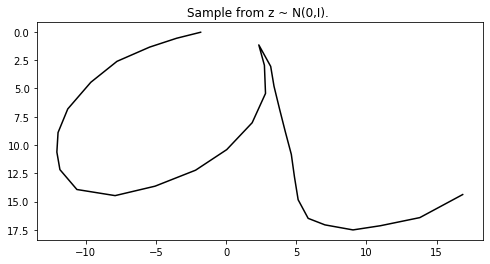

In [0]:
new_pred = get_one_hot(sample)
strokes_pred = toStroke3(new_pred)
coords_pred = offsets_to_coordinates(strokes_pred)

for i in range(len(coords_pred)):
  visualize_sample(coords_pred, i)

In [0]:
def plot_in_line(coordinates, mode='horizontal', save=None):
    """ 
    Visualizes stroke3 coordinates
    Args:
        coordinate: list or numpy object of all the sequence of stroke
        characters: list or numpy object  of all characters represented
        i: Int. Index of the character to represent with the sequence of strokes
    """
    n = len(coordinates)
    if mode == "vertical":
      fig, ax = plt.subplots(n, figsize=(4,16))
    elif mode == "horizontal":
      fig, ax = plt.subplots(1,n,sharex='col', figsize=(24,2))
    else:
      raise ValueError("mode should be equal to vertical or horizontal.")
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(n):    
      coords_ = coordinates[i]        
      ax[i].invert_yaxis()       
      stroke = []
      # import pdb; pdb.set_trace()
      for x, y, eos in coords_:
          stroke.append((x, y))
          if eos == 1:
              x_and_y = list(zip(*stroke))
              if i == 0 or i == (n-1):
                ax[i].plot(x_and_y[0], x_and_y[1], 'k') 
              else:
                 ax[i].plot(x_and_y[0], x_and_y[1], 'b') 
              ax[i].set_axis_off()                                             
              stroke = []  
      fig.suptitle("Black: real data. Blue: generated data in between the real data", fontsize=14)        
      if save is not None:
          fig.savefig("interpolation.png")        


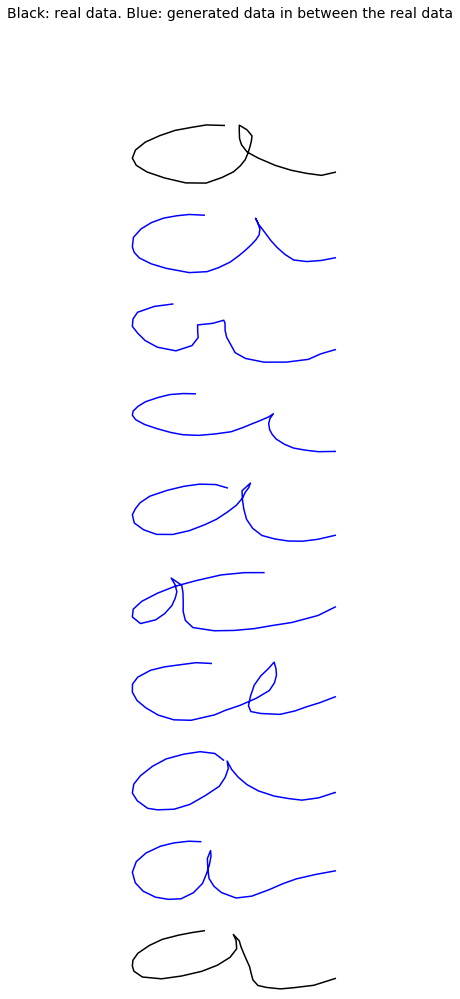

In [0]:
plot_in_line(coords_pred, mode="vertical")